In [1]:
!pip install geoplot
!pip install contextily
!pip install altair

In [2]:
import pandas as pd 
import geopandas as gpd 
import nltk
nltk.download('punkt')
import contextily as ctx
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import folium
import numpy as np
import seaborn as sns
import altair as alt 

[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


# Part I : Obtention du dataframe 
## 1.1.Récupération des loyers, des surfaces et de la localisation des résidences

In [3]:
df = pd.read_csv("fr_crous_logement_france_entiere.csv", sep =';')


In [4]:
df = df[["title", "infos", "address" ,"geocalisation", "regions"]]

In [5]:
from functions_for_data_cleaning import *

df = get_loyer(df)
df = get_surface(df)
df = get_localisation(df) 
df

[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/onyxia/work/Immobilier-etudiant-/functions_for_data_cleaning.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Surface'][j] = remove(df['Surface'][j], 7, 100)


,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry
0,Résidence Vauban,Description La résidence est située au cœur de...,1 boulevard d’Alembert 78280 Guyancourt,"48.7796516418,2.0441513062",Île-de-France,"[333.0, 537.0]",537.00,333.00,435.000000,[],NaN,NaN,NaN,2.044151,48.779652,POINT (2.04415 48.77965)
1,Résidence Le Square de l'Echiquier,DescriptionRésidence universitaire nouvellemen...,9 square de l'échiquier 95800 Cergy-Pontoise,"49.0482978821,2.02688694",Île-de-France,[334.0],334.00,334.00,334.000000,[],NaN,NaN,NaN,2.026887,49.048298,POINT (2.02689 49.04830)
2,Résidence Les Bas Longchamps,Description Résidence universitaire située à p...,2 rue Abraham Lincoln 92220 Bagneux,"48.7906913757,2.3169708252",Île-de-France,"[332.0, 359.0]",359.00,332.00,345.500000,[28.0],28.0,28.0,28.000000,2.316971,48.790691,POINT (2.31697 48.79069)
3,Résidence de l’Ile,Description Résidence universitaire située à p...,14 rue du Docteur Collé - bâtiment 227 du camp...,"48.698802948,2.1578958035",Île-de-France,[362.0],362.00,362.00,362.000000,[18.0],18.0,18.0,18.000000,2.157896,48.698803,POINT (2.15790 48.69880)
4,Résidence La Pacaterie,Description Résidence universitaire longée par...,Bâtiment 499 - rue de la Pacaterie 91400 Orsay,"48.7015419006,2.1846776009",Île-de-France,[154.0],154.00,154.00,154.000000,[],NaN,NaN,NaN,2.184678,48.701542,POINT (2.18468 48.70154)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,Cité Grémillon (secteur d'Hérouville-Saint-Clair),BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,"49.2032051086,-0.3392136097",Normandie,"[249.85, 312.9, 388.6, 467.4, 525.0, 556.14]",556.14,249.85,416.648333,"[9.0, 18.0, 30.0, 49.0, 65.0, 69.0]",69.0,9.0,40.000000,-0.339214,49.203205,POINT (-0.33921 49.20321)
784,Résidence Antide Janvier,"Localisation :\r\n Au centre ville, à proximit...",6 rue Antide Janvier 25000 Besançon,"47.2365074158,6.0153431892",Bourgogne-Franche-Comté,"[347.0, 502.0, 523.0]",523.00,347.00,457.333333,"[19.0, 35.3]",35.3,19.0,27.150000,6.015343,47.236507,POINT (6.01534 47.23651)
785,Résidence Jean Paul Sartre,Localisation :\r\n La résidence Sartre est sit...,Rue Gaston Deferre 90000 Belfort,"47.6389884949,6.8537139893",Bourgogne-Franche-Comté,"[280.0, 311.0, 361.0, 405.0, 416.0, 466.0, 586.0]",586.00,280.00,403.571429,"[18.0, 36.0, 51.5]",51.5,18.0,35.166667,6.853714,47.638988,POINT (6.85371 47.63899)
786,Maret,NaN,3 rue du Docteur Maret 21000 Dijon,"47.3224983215,5.0353322029",Bourgogne-Franche-Comté,None,NaN,NaN,NaN,None,NaN,NaN,NaN,5.035332,47.322498,POINT (5.03533 47.32250)


## 1.2.Récupération des loyers privés des communes (avec la géolocalisation des communes)

In [6]:
df_private = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/8fac6fb7-cd07-4747-8e0b-b101c476f0da", encoding= 'unicode_escape', sep = ";")


On ne garde que le code INSEE, le nom de la ville et le loyer supérieur par m^2


In [7]:
df_private = df_private[["INSEE", "LIBGEO","upr.IPm2"]]

On renomme la colonne INSEE en codgeo pour pouvoir la merger avec la carte des contours des villes.

In [8]:
df_private.rename(columns = {'INSEE':'codgeo'}, inplace = True)

In [9]:
"""
On rajoute un 0 devant le code INSEE quand il ne fait que quatre chiffres (pour uniformiser avec l'autre base).
"""
for i in range(0,df_private.shape[0]):
    if  len(df_private["codgeo"][i]) == 4: 
            df_private["codgeo"][i] = "0" +  df_private["codgeo"][i]

In [10]:
df_private = df_private.set_index('codgeo') #on réindex le dataframe avec le code INSEE pour merger après. 

On récuppère les contours géographique des communes.(prends du temps)

In [11]:
gdf_communes_boundaries = gpd.read_file("https://www.data.gouv.fr/fr/datasets/r/e9391593-fa95-4153-aabe-87ca84d197e9")

On ne garde que le code INSEE et les données polygoniales. 

In [12]:
gdf_communes_boundaries.rename(columns = {'INSEE_COM':'codgeo'}, inplace = True)
gdf_communes_boundaries = gdf_communes_boundaries[["codgeo", "geometry"]]
gdf_communes_boundaries = gdf_communes_boundaries.set_index('codgeo')


On concatène les deux datafarmes

In [13]:
gdf_private = pd.concat([df_private,gdf_communes_boundaries], axis = 1, join = "inner")

## 1.3. Jointures spatiales

In [14]:

#gdf_private['geometry'] = gdf_private['geometry'].apply(wkt.loads) #on transforme en format wkt (sinon ça ne marche pas)
gdf_private = gpd.GeoDataFrame(gdf_private)  #on transforme en geodataframe 
df = gpd.sjoin(df, gdf_private, how='left', op='within') #on réalise la jointure à gauche avec within 
#i.e si le point est dans le polynôme. 

/opt/mamba/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_1182/2580680376.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  df = gpd.sjoin(df, gdf_private, how='left', op='within') #on réalise la jointure à gauche avec within


In [15]:
del df['index_right'] #on supprime l'index right pour la prochaine jointure
df

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2
0,Résidence Vauban,Description La résidence est située au cœur de...,1 boulevard d’Alembert 78280 Guyancourt,"48.7796516418,2.0441513062",Île-de-France,"[333.0, 537.0]",537.00,333.00,435.000000,[],NaN,NaN,NaN,2.044151,48.779652,POINT (2.04415 48.77965),Guyancourt,"21,73842264"
1,Résidence Le Square de l'Echiquier,DescriptionRésidence universitaire nouvellemen...,9 square de l'échiquier 95800 Cergy-Pontoise,"49.0482978821,2.02688694",Île-de-France,[334.0],334.00,334.00,334.000000,[],NaN,NaN,NaN,2.026887,49.048298,POINT (2.02689 49.04830),Cergy,"20,65371054"
2,Résidence Les Bas Longchamps,Description Résidence universitaire située à p...,2 rue Abraham Lincoln 92220 Bagneux,"48.7906913757,2.3169708252",Île-de-France,"[332.0, 359.0]",359.00,332.00,345.500000,[28.0],28.0,28.0,28.000000,2.316971,48.790691,POINT (2.31697 48.79069),Bagneux,"24,98281618"
3,Résidence de l’Ile,Description Résidence universitaire située à p...,14 rue du Docteur Collé - bâtiment 227 du camp...,"48.698802948,2.1578958035",Île-de-France,[362.0],362.00,362.00,362.000000,[18.0],18.0,18.0,18.000000,2.157896,48.698803,POINT (2.15790 48.69880),Bures-sur-Yvette,"21,2713506"
4,Résidence La Pacaterie,Description Résidence universitaire longée par...,Bâtiment 499 - rue de la Pacaterie 91400 Orsay,"48.7015419006,2.1846776009",Île-de-France,[154.0],154.00,154.00,154.000000,[],NaN,NaN,NaN,2.184678,48.701542,POINT (2.18468 48.70154),Orsay,"21,07028697"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,Cité Grémillon (secteur d'Hérouville-Saint-Clair),BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,"49.2032051086,-0.3392136097",Normandie,"[249.85, 312.9, 388.6, 467.4, 525.0, 556.14]",556.14,249.85,416.648333,"[9.0, 18.0, 30.0, 49.0, 65.0, 69.0]",69.0,9.0,40.000000,-0.339214,49.203205,POINT (-0.33921 49.20321),Hérouville-Saint-Clair,"13,70540711"
784,Résidence Antide Janvier,"Localisation :\r\n Au centre ville, à proximit...",6 rue Antide Janvier 25000 Besançon,"47.2365074158,6.0153431892",Bourgogne-Franche-Comté,"[347.0, 502.0, 523.0]",523.00,347.00,457.333333,"[19.0, 35.3]",35.3,19.0,27.150000,6.015343,47.236507,POINT (6.01534 47.23651),Besançon,"13,92609502"
785,Résidence Jean Paul Sartre,Localisation :\r\n La résidence Sartre est sit...,Rue Gaston Deferre 90000 Belfort,"47.6389884949,6.8537139893",Bourgogne-Franche-Comté,"[280.0, 311.0, 361.0, 405.0, 416.0, 466.0, 586.0]",586.00,280.00,403.571429,"[18.0, 36.0, 51.5]",51.5,18.0,35.166667,6.853714,47.638988,POINT (6.85371 47.63899),Belfort,"13,04684054"
786,Maret,NaN,3 rue du Docteur Maret 21000 Dijon,"47.3224983215,5.0353322029",Bourgogne-Franche-Comté,None,NaN,NaN,NaN,None,NaN,NaN,NaN,5.035332,47.322498,POINT (5.03533 47.32250),Dijon,"14,38634283"


## 1.4 Ajout des départements 

In [16]:
gdf_dep = gpd.read_file("https://www.data.gouv.fr/fr/datasets/r/eb36371a-761d-44a8-93ec-3d728bec17ce")
gdf_dep.rename(columns = {'nom':'departement'}, inplace = True)
gdf_dep = gdf_dep[["departement", "geometry"]]
gdf_dep

,departement,geometry
0,La Réunion,"MULTIPOLYGON (((55.21643 -21.03904, 55.21652 -..."
1,Aude,"POLYGON ((1.68872 43.27368, 1.69001 43.27423, ..."
2,Haute-Loire,"POLYGON ((3.08206 45.28988, 3.08209 45.29031, ..."
3,Bouches-du-Rhône,"MULTIPOLYGON (((4.23014 43.46047, 4.23025 43.4..."
4,Lot-et-Garonne,"POLYGON ((-0.14058 44.22648, -0.12931 44.23218..."
...,...,...
97,Morbihan,"MULTIPOLYGON (((-3.73508 48.11140, -3.73507 48..."
98,Doubs,"POLYGON ((5.69876 47.26464, 5.69877 47.26481, ..."
99,Jura,"MULTIPOLYGON (((5.25202 46.94451, 5.25208 46.9..."
100,Ardèche,"POLYGON ((3.86110 44.71118, 3.86110 44.71151, ..."


In [17]:
df = gpd.sjoin(df, gdf_dep, how='left', op='within')


/opt/mamba/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_1182/3352756710.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  df = gpd.sjoin(df, gdf_dep, how='left', op='within')


In [18]:
df

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2,index_right,departement
0,Résidence Vauban,Description La résidence est située au cœur de...,1 boulevard d’Alembert 78280 Guyancourt,"48.7796516418,2.0441513062",Île-de-France,"[333.0, 537.0]",537.00,333.00,435.000000,[],NaN,NaN,NaN,2.044151,48.779652,POINT (2.04415 48.77965),Guyancourt,"21,73842264",73,Yvelines
1,Résidence Le Square de l'Echiquier,DescriptionRésidence universitaire nouvellemen...,9 square de l'échiquier 95800 Cergy-Pontoise,"49.0482978821,2.02688694",Île-de-France,[334.0],334.00,334.00,334.000000,[],NaN,NaN,NaN,2.026887,49.048298,POINT (2.02689 49.04830),Cergy,"20,65371054",67,Val-d'Oise
2,Résidence Les Bas Longchamps,Description Résidence universitaire située à p...,2 rue Abraham Lincoln 92220 Bagneux,"48.7906913757,2.3169708252",Île-de-France,"[332.0, 359.0]",359.00,332.00,345.500000,[28.0],28.0,28.0,28.000000,2.316971,48.790691,POINT (2.31697 48.79069),Bagneux,"24,98281618",35,Hauts-de-Seine
3,Résidence de l’Ile,Description Résidence universitaire située à p...,14 rue du Docteur Collé - bâtiment 227 du camp...,"48.698802948,2.1578958035",Île-de-France,[362.0],362.00,362.00,362.000000,[18.0],18.0,18.0,18.000000,2.157896,48.698803,POINT (2.15790 48.69880),Bures-sur-Yvette,"21,2713506",8,Essonne
4,Résidence La Pacaterie,Description Résidence universitaire longée par...,Bâtiment 499 - rue de la Pacaterie 91400 Orsay,"48.7015419006,2.1846776009",Île-de-France,[154.0],154.00,154.00,154.000000,[],NaN,NaN,NaN,2.184678,48.701542,POINT (2.18468 48.70154),Orsay,"21,07028697",8,Essonne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,Cité Grémillon (secteur d'Hérouville-Saint-Clair),BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,"49.2032051086,-0.3392136097",Normandie,"[249.85, 312.9, 388.6, 467.4, 525.0, 556.14]",556.14,249.85,416.648333,"[9.0, 18.0, 30.0, 49.0, 65.0, 69.0]",69.0,9.0,40.000000,-0.339214,49.203205,POINT (-0.33921 49.20321),Hérouville-Saint-Clair,"13,70540711",69,Calvados
784,Résidence Antide Janvier,"Localisation :\r\n Au centre ville, à proximit...",6 rue Antide Janvier 25000 Besançon,"47.2365074158,6.0153431892",Bourgogne-Franche-Comté,"[347.0, 502.0, 523.0]",523.00,347.00,457.333333,"[19.0, 35.3]",35.3,19.0,27.150000,6.015343,47.236507,POINT (6.01534 47.23651),Besançon,"13,92609502",98,Doubs
785,Résidence Jean Paul Sartre,Localisation :\r\n La résidence Sartre est sit...,Rue Gaston Deferre 90000 Belfort,"47.6389884949,6.8537139893",Bourgogne-Franche-Comté,"[280.0, 311.0, 361.0, 405.0, 416.0, 466.0, 586.0]",586.00,280.00,403.571429,"[18.0, 36.0, 51.5]",51.5,18.0,35.166667,6.853714,47.638988,POINT (6.85371 47.63899),Belfort,"13,04684054",86,Territoire-de-Belfort
786,Maret,NaN,3 rue du Docteur Maret 21000 Dijon,"47.3224983215,5.0353322029",Bourgogne-Franche-Comté,None,NaN,NaN,NaN,None,NaN,NaN,NaN,5.035332,47.322498,POINT (5.03533 47.32250),Dijon,"14,38634283",78,Côte-d'Or


In [19]:
del df['index_right'] #on supprime l'index right pour la prochaine jointure
df

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2,departement
0,Résidence Vauban,Description La résidence est située au cœur de...,1 boulevard d’Alembert 78280 Guyancourt,"48.7796516418,2.0441513062",Île-de-France,"[333.0, 537.0]",537.00,333.00,435.000000,[],NaN,NaN,NaN,2.044151,48.779652,POINT (2.04415 48.77965),Guyancourt,"21,73842264",Yvelines
1,Résidence Le Square de l'Echiquier,DescriptionRésidence universitaire nouvellemen...,9 square de l'échiquier 95800 Cergy-Pontoise,"49.0482978821,2.02688694",Île-de-France,[334.0],334.00,334.00,334.000000,[],NaN,NaN,NaN,2.026887,49.048298,POINT (2.02689 49.04830),Cergy,"20,65371054",Val-d'Oise
2,Résidence Les Bas Longchamps,Description Résidence universitaire située à p...,2 rue Abraham Lincoln 92220 Bagneux,"48.7906913757,2.3169708252",Île-de-France,"[332.0, 359.0]",359.00,332.00,345.500000,[28.0],28.0,28.0,28.000000,2.316971,48.790691,POINT (2.31697 48.79069),Bagneux,"24,98281618",Hauts-de-Seine
3,Résidence de l’Ile,Description Résidence universitaire située à p...,14 rue du Docteur Collé - bâtiment 227 du camp...,"48.698802948,2.1578958035",Île-de-France,[362.0],362.00,362.00,362.000000,[18.0],18.0,18.0,18.000000,2.157896,48.698803,POINT (2.15790 48.69880),Bures-sur-Yvette,"21,2713506",Essonne
4,Résidence La Pacaterie,Description Résidence universitaire longée par...,Bâtiment 499 - rue de la Pacaterie 91400 Orsay,"48.7015419006,2.1846776009",Île-de-France,[154.0],154.00,154.00,154.000000,[],NaN,NaN,NaN,2.184678,48.701542,POINT (2.18468 48.70154),Orsay,"21,07028697",Essonne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,Cité Grémillon (secteur d'Hérouville-Saint-Clair),BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,"49.2032051086,-0.3392136097",Normandie,"[249.85, 312.9, 388.6, 467.4, 525.0, 556.14]",556.14,249.85,416.648333,"[9.0, 18.0, 30.0, 49.0, 65.0, 69.0]",69.0,9.0,40.000000,-0.339214,49.203205,POINT (-0.33921 49.20321),Hérouville-Saint-Clair,"13,70540711",Calvados
784,Résidence Antide Janvier,"Localisation :\r\n Au centre ville, à proximit...",6 rue Antide Janvier 25000 Besançon,"47.2365074158,6.0153431892",Bourgogne-Franche-Comté,"[347.0, 502.0, 523.0]",523.00,347.00,457.333333,"[19.0, 35.3]",35.3,19.0,27.150000,6.015343,47.236507,POINT (6.01534 47.23651),Besançon,"13,92609502",Doubs
785,Résidence Jean Paul Sartre,Localisation :\r\n La résidence Sartre est sit...,Rue Gaston Deferre 90000 Belfort,"47.6389884949,6.8537139893",Bourgogne-Franche-Comté,"[280.0, 311.0, 361.0, 405.0, 416.0, 466.0, 586.0]",586.00,280.00,403.571429,"[18.0, 36.0, 51.5]",51.5,18.0,35.166667,6.853714,47.638988,POINT (6.85371 47.63899),Belfort,"13,04684054",Territoire-de-Belfort
786,Maret,NaN,3 rue du Docteur Maret 21000 Dijon,"47.3224983215,5.0353322029",Bourgogne-Franche-Comté,None,NaN,NaN,NaN,None,NaN,NaN,NaN,5.035332,47.322498,POINT (5.03533 47.32250),Dijon,"14,38634283",Côte-d'Or


## 1.5. Association de résidences à une école 

In [20]:
df.crs = "epsg:4326" #on définit la projection de notre dataframe

In [21]:
"""
Calcul d'un cercle de 20 km autour de la résidence
"""
df1 = df
df1 = df1.to_crs(epsg = 3395) #On prend une projection en mètres
df1['geometry'] = df1['geometry'].buffer(20000) #On prend un rayon de 20km 
df1 = df1.to_crs(4326) #on repasse dans la projection uselle 
df1

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2,departement
0,Résidence Vauban,Description La résidence est située au cœur de...,1 boulevard d’Alembert 78280 Guyancourt,"48.7796516418,2.0441513062",Île-de-France,"[333.0, 537.0]",537.00,333.00,435.000000,[],NaN,NaN,NaN,2.044151,48.779652,"POLYGON ((2.22381 48.77965, 2.22295 48.76801, ...",Guyancourt,"21,73842264",Yvelines
1,Résidence Le Square de l'Echiquier,DescriptionRésidence universitaire nouvellemen...,9 square de l'échiquier 95800 Cergy-Pontoise,"49.0482978821,2.02688694",Île-de-France,[334.0],334.00,334.00,334.000000,[],NaN,NaN,NaN,2.026887,49.048298,"POLYGON ((2.20655 49.04830, 2.20568 49.03672, ...",Cergy,"20,65371054",Val-d'Oise
2,Résidence Les Bas Longchamps,Description Résidence universitaire située à p...,2 rue Abraham Lincoln 92220 Bagneux,"48.7906913757,2.3169708252",Île-de-France,"[332.0, 359.0]",359.00,332.00,345.500000,[28.0],28.0,28.0,28.000000,2.316971,48.790691,"POLYGON ((2.49663 48.79069, 2.49577 48.77905, ...",Bagneux,"24,98281618",Hauts-de-Seine
3,Résidence de l’Ile,Description Résidence universitaire située à p...,14 rue du Docteur Collé - bâtiment 227 du camp...,"48.698802948,2.1578958035",Île-de-France,[362.0],362.00,362.00,362.000000,[18.0],18.0,18.0,18.000000,2.157896,48.698803,"POLYGON ((2.33756 48.69880, 2.33669 48.68714, ...",Bures-sur-Yvette,"21,2713506",Essonne
4,Résidence La Pacaterie,Description Résidence universitaire longée par...,Bâtiment 499 - rue de la Pacaterie 91400 Orsay,"48.7015419006,2.1846776009",Île-de-France,[154.0],154.00,154.00,154.000000,[],NaN,NaN,NaN,2.184678,48.701542,"POLYGON ((2.36434 48.70154, 2.36348 48.68988, ...",Orsay,"21,07028697",Essonne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,Cité Grémillon (secteur d'Hérouville-Saint-Clair),BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,"49.2032051086,-0.3392136097",Normandie,"[249.85, 312.9, 388.6, 467.4, 525.0, 556.14]",556.14,249.85,416.648333,"[9.0, 18.0, 30.0, 49.0, 65.0, 69.0]",69.0,9.0,40.000000,-0.339214,49.203205,"POLYGON ((-0.15955 49.20321, -0.16042 49.19166...",Hérouville-Saint-Clair,"13,70540711",Calvados
784,Résidence Antide Janvier,"Localisation :\r\n Au centre ville, à proximit...",6 rue Antide Janvier 25000 Besançon,"47.2365074158,6.0153431892",Bourgogne-Franche-Comté,"[347.0, 502.0, 523.0]",523.00,347.00,457.333333,"[19.0, 35.3]",35.3,19.0,27.150000,6.015343,47.236507,"POLYGON ((6.19501 47.23651, 6.19414 47.22451, ...",Besançon,"13,92609502",Doubs
785,Résidence Jean Paul Sartre,Localisation :\r\n La résidence Sartre est sit...,Rue Gaston Deferre 90000 Belfort,"47.6389884949,6.8537139893",Bourgogne-Franche-Comté,"[280.0, 311.0, 361.0, 405.0, 416.0, 466.0, 586.0]",586.00,280.00,403.571429,"[18.0, 36.0, 51.5]",51.5,18.0,35.166667,6.853714,47.638988,"POLYGON ((7.03338 47.63899, 7.03251 47.62709, ...",Belfort,"13,04684054",Territoire-de-Belfort
786,Maret,NaN,3 rue du Docteur Maret 21000 Dijon,"47.3224983215,5.0353322029",Bourgogne-Franche-Comté,None,NaN,NaN,NaN,None,NaN,NaN,NaN,5.035332,47.322498,"POLYGON ((5.21500 47.32250, 5.21413 47.31052, ...",Dijon,"14,38634283",Côte-d'Or


In [22]:
"""
Import de notre base de données des écoles 
"""
df_schools = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/0c713161-26fb-415e-ac1d-8769125f338d", sep = ";")

In [23]:
df_schools = df_schools[df_schools["annee_universitaire"] == "2021-22" ] #on ne prend que l'année 2021-22
df_schools = df_schools[["etablissement_lib", "effectif_sans_cpge", "etablissement_code_commune", "etablissement_commune"]]

In [24]:
df_schools

,etablissement_lib,effectif_sans_cpge,etablissement_code_commune,etablissement_commune
427,Université de Strasbourg,54534,67482,Strasbourg
428,Université Toulouse Capitole,17867,31555,Toulouse
429,École nationale supérieure des sciences de l'i...,234,69266,Villeurbanne
430,Université Paris 1 - Panthéon Sorbonne,40413,75105,Paris 5e
431,Université Jean Moulin - Lyon 3,25559,69387,Lyon 7e
...,...,...,...,...
2283,École nationale supérieure de l'électronique e...,874,95127,Cergy
2284,Université Paris-Est Créteil,39198,94028,Créteil
2285,Aix-Marseille Université,71711,13207,Marseille 7e
2286,École nationale supérieure des arts et techniq...,216,69385,Lyon 5e


In [25]:
df_schools.rename(columns = {'etablissement_code_commune':'codgeo'}, inplace = True) #On renomme la colonne pour la jointure


In [26]:
index_with_nan = df_schools.index[df_schools.isnull().any(axis=1)]
df_schools.drop(index_with_nan,0, inplace=True) #on enlève les valeurs manquantes

/tmp/ipykernel_1182/123655656.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_schools.drop(index_with_nan,0, inplace=True) #on enlève les valeurs manquantes


In [27]:
df_schools.set_index('codgeo', inplace = True)
df_schools

,etablissement_lib,effectif_sans_cpge,etablissement_commune
codgeo,,,
67482,Université de Strasbourg,54534,Strasbourg
31555,Université Toulouse Capitole,17867,Toulouse
69266,École nationale supérieure des sciences de l'i...,234,Villeurbanne
75105,Université Paris 1 - Panthéon Sorbonne,40413,Paris 5e
69387,Université Jean Moulin - Lyon 3,25559,Lyon 7e
...,...,...,...
95127,École nationale supérieure de l'électronique e...,874,Cergy
94028,Université Paris-Est Créteil,39198,Créteil
13207,Aix-Marseille Université,71711,Marseille 7e


In [28]:
df_schools = df_schools.join(gdf_communes_boundaries)
df_schools

,etablissement_lib,effectif_sans_cpge,etablissement_commune,geometry
codgeo,,,,
06088,Université Côte d'Azur,33537,Nice,"POLYGON ((7.32125 43.72359, 7.32113 43.72360, ..."
10387,Université de technologie de Troyes,3235,Troyes,"POLYGON ((4.05058 48.29937, 4.05137 48.29921, ..."
13001,Sciences Po Aix,1682,Aix-en-Provence,"POLYGON ((5.50459 43.53231, 5.50421 43.53234, ..."
13207,Aix-Marseille Université,71711,Marseille 7e,"MULTIPOLYGON (((5.28590 43.26396, 5.28588 43.2..."
13213,Centrale Marseille,1165,Marseille 13e,"POLYGON ((5.41084 43.31492, 5.41150 43.31484, ..."
...,...,...,...,...
97302,Université de Guyane,3890,Cayenne,"MULTIPOLYGON (((-52.16862 4.88872, -52.16870 4..."
97411,Université de La Réunion,17044,Saint-Denis,"POLYGON ((55.46906 -21.00973, 55.47105 -21.008..."
97607,Centre universitaire de Mayotte,1335,Dembeni,"POLYGON ((45.16908 -12.88110, 45.17800 -12.886..."


In [29]:
df_schools = gpd.GeoDataFrame(df_schools)
df_schools.crs = "epsg:4326"

In [30]:
"""
essai sur la résidence de Cergy 
"""
a = df_schools.within(df1["geometry"][1])
i = 0 
for element in a : 
    if element == True: 
        print(df_schools['etablissement_lib'][i])
    i = i + 1

CY Cergy Paris Université
École nationale supérieure de l'électronique et de ses applications de Cergy


In [31]:
Schools = [] #on crée une liste pour stocker la liste des écoles 
Nbstudents = [] #on crée une liste pour stocker la liste du nombre d'étudiants
Nbstudents_total  = []
for residence in df1["geometry"]: #on prend pour chaque résidence le cercle de 5 km autour de cette résidence
    S = [] #stocke les écoles pour la résidence
    N = [] #idem pour le nb d'étudiants 
    i = 0 #index 
    a = df_schools.within(residence) #On utilise gpd.within qui regarde pour chaque élèment si sa coordonnée est dans le polygone résidence
    for element in a : #on regarde pour chaque élèment de a si l'école est dans le cercle de 5km autour de la résidence
        if element == True: 
            S.append(df_schools['etablissement_lib'][i]) #on ajoute l'école de l'index i 
            N.append(df_schools['effectif_sans_cpge'][i]) #idem pour le nombre d'étudiants
        i = i + 1
    Schools.append(S) 
    Nbstudents.append(N)
    Nbstudents_total.append(sum(N))
df['Schools'] = Schools
df['Nbstudents'] = Nbstudents
df['Nbstudents_total'] = Nbstudents_total
df
       

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,...,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2,departement,Schools,Nbstudents,Nbstudents_total
0,Résidence Vauban,Description La résidence est située au cœur de...,1 boulevard d’Alembert 78280 Guyancourt,"48.7796516418,2.0441513062",Île-de-France,"[333.0, 537.0]",537.00,333.00,435.000000,[],...,NaN,2.044151,48.779652,POINT (2.04415 48.77965),Guyancourt,"21,73842264",Yvelines,[Université de Versailles Saint-Quentin-en-Yve...,"[14583, 48595]",63178
1,Résidence Le Square de l'Echiquier,DescriptionRésidence universitaire nouvellemen...,9 square de l'échiquier 95800 Cergy-Pontoise,"49.0482978821,2.02688694",Île-de-France,[334.0],334.00,334.00,334.000000,[],...,NaN,2.026887,49.048298,POINT (2.02689 49.04830),Cergy,"20,65371054",Val-d'Oise,"[CY Cergy Paris Université, École nationale su...","[26069, 874]",26943
2,Résidence Les Bas Longchamps,Description Résidence universitaire située à p...,2 rue Abraham Lincoln 92220 Bagneux,"48.7906913757,2.3169708252",Île-de-France,"[332.0, 359.0]",359.00,332.00,345.500000,[28.0],...,28.000000,2.316971,48.790691,POINT (2.31697 48.79069),Bagneux,"24,98281618",Hauts-de-Seine,"[Université Paris Lumières, Université Paris 1...","[78, 40413, 15404, 1937, 22246, 422, 52969, 59...",275639
3,Résidence de l’Ile,Description Résidence universitaire située à p...,14 rue du Docteur Collé - bâtiment 227 du camp...,"48.698802948,2.1578958035",Île-de-France,[362.0],362.00,362.00,362.000000,[18.0],...,18.000000,2.157896,48.698803,POINT (2.15790 48.69880),Bures-sur-Yvette,"21,2713506",Essonne,[Université Paris-Saclay],[48595],48595
4,Résidence La Pacaterie,Description Résidence universitaire longée par...,Bâtiment 499 - rue de la Pacaterie 91400 Orsay,"48.7015419006,2.1846776009",Île-de-France,[154.0],154.00,154.00,154.000000,[],...,NaN,2.184678,48.701542,POINT (2.18468 48.70154),Orsay,"21,07028697",Essonne,[Université Paris-Saclay],[48595],48595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,Cité Grémillon (secteur d'Hérouville-Saint-Clair),BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,"49.2032051086,-0.3392136097",Normandie,"[249.85, 312.9, 388.6, 467.4, 525.0, 556.14]",556.14,249.85,416.648333,"[9.0, 18.0, 30.0, 49.0, 65.0, 69.0]",...,40.000000,-0.339214,49.203205,POINT (-0.33921 49.20321),Hérouville-Saint-Clair,"13,70540711",Calvados,[École nationale supérieure d'ingénieurs de Ca...,"[845, 32088]",32933
784,Résidence Antide Janvier,"Localisation :\r\n Au centre ville, à proximit...",6 rue Antide Janvier 25000 Besançon,"47.2365074158,6.0153431892",Bourgogne-Franche-Comté,"[347.0, 502.0, 523.0]",523.00,347.00,457.333333,"[19.0, 35.3]",...,27.150000,6.015343,47.236507,POINT (6.01534 47.23651),Besançon,"13,92609502",Doubs,"[Université Bourgogne - Franche-Comté, École n...","[2077, 779, 23578]",26434
785,Résidence Jean Paul Sartre,Localisation :\r\n La résidence Sartre est sit...,Rue Gaston Deferre 90000 Belfort,"47.6389884949,6.8537139893",Bourgogne-Franche-Comté,"[280.0, 311.0, 361.0, 405.0, 416.0, 466.0, 586.0]",586.00,280.00,403.571429,"[18.0, 36.0, 51.5]",...,35.166667,6.853714,47.638988,POINT (6.85371 47.63899),Belfort,"13,04684054",Territoire-de-Belfort,[Université de technologie de Belfort-Montbéli...,[2641],2641
786,Maret,NaN,3 rue du Docteur Maret 21000 Dijon,"47.3224983215,5.0353322029",Bourgogne-Franche-Comté,None,NaN,NaN,NaN,None,...,NaN,5.035332,47.322498,POINT (5.03533 47.32250),Dijon,"14,38634283",Côte-d'Or,[Université de Bourgogne],[31341],31341


# II. Visualisation 

## 2.1 Portrait économique et statistique des résidences

In [32]:
df['prix_par_m2_min'] = df['Min Loyer']/df['Min Surface'] # On crée une nouvelle variable prix_par_m2_min 

In [33]:
df["upr.IPm2"] = df["upr.IPm2"].apply(lambda x : x.replace(',', '.')) #on remplace les , par des points pour ensuite transformet cette colonne en float


In [34]:
df["upr.IPm2"] = df["upr.IPm2"].astype(float)

In [35]:
df.groupby(['departement']).mean().sort_values('prix_par_m2_min')

/tmp/ipykernel_1182/1064917290.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['departement']).mean().sort_values('prix_par_m2_min')


,Max Loyer,Min Loyer,Mean Loyer,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,upr.IPm2,Nbstudents_total,prix_par_m2_min
departement,,,,,,,,,,,
Vaucluse,393.535714,246.552857,308.777857,30.087143,23.815714,26.951429,4.828818,43.944533,14.315362,6787.000000,11.476546
Aisne,307.750000,261.670000,284.710000,20.700000,20.700000,20.700000,3.302897,49.841917,11.992983,0.000000,12.683688
Pyrénées-Orientales,377.166667,313.833333,346.083333,34.000000,26.200000,30.100000,2.895255,42.685872,12.694461,8569.000000,12.685152
Gard,413.138333,325.600000,365.063611,40.500000,25.250000,31.375000,4.357343,43.832422,13.606911,5459.000000,13.134632
Seine-et-Marne,405.333333,318.333333,360.314815,34.000000,23.555556,28.648148,2.596910,48.702632,19.202476,8821.555556,13.803151
...,...,...,...,...,...,...,...,...,...,...,...
Saône-et-Loire,NaN,NaN,NaN,NaN,NaN,NaN,4.428220,46.806198,10.567857,0.000000,NaN
Tarn,NaN,NaN,NaN,23.750000,21.250000,22.500000,2.168522,43.842574,11.575138,2806.500000,NaN
Val-d'Oise,364.700000,288.857143,326.778571,NaN,NaN,NaN,2.065076,49.036170,20.620895,26943.000000,NaN


## Construction des graphiques 

In [36]:
df2 = df.groupby(['departement']).mean().sort_values('prix_par_m2_min')
df2 = df2.loc[(df2['prix_par_m2_min']>1)] 

/tmp/ipykernel_1182/2237300556.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['departement']).mean().sort_values('prix_par_m2_min')


In [37]:
df2['departement'] = df2.index #je crée une colonne qui correspond à l'index (la colonne regions)

<AxesSubplot: xlabel='prix_par_m2_min', ylabel='departement'>

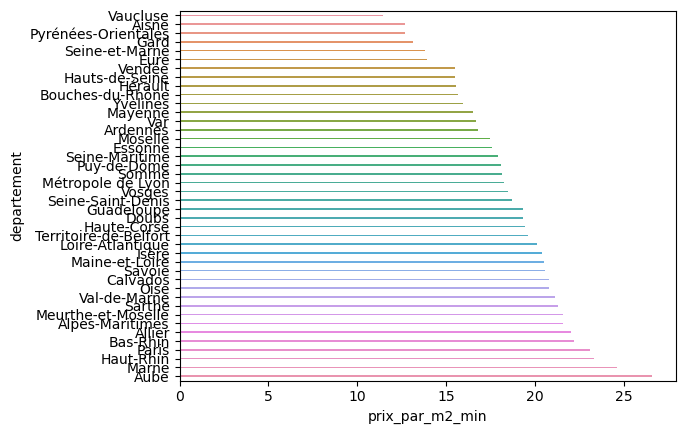

In [38]:
sns.barplot(y='departement', x='prix_par_m2_min', data=df2, width= 0.2, orient="h")

## Ajout de la colonne 'prix_par_m2_max'(qui correspond le plus souvent à des logements en colocation (T2/T3/T4))

In [39]:
df['prix_par_m2_max'] = df['Max Loyer']/df['Max Surface'] # On crée une nouvelle variable prix_par_m2_min 

In [40]:
df.groupby(['departement']).mean().sort_values('prix_par_m2_max')

/tmp/ipykernel_1182/2332010617.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['departement']).mean().sort_values('prix_par_m2_max')


,Max Loyer,Min Loyer,Mean Loyer,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,upr.IPm2,Nbstudents_total,prix_par_m2_min,prix_par_m2_max
departement,,,,,,,,,,,,
Métropole de Lyon,384.258065,291.193548,334.958871,91.00,18.00,48.083333,4.852303,45.756218,18.146949,110640.125000,18.250000,4.496288
Eure,385.400000,265.800000,318.800000,45.00,19.00,30.291667,1.142002,49.025866,13.446488,0.000000,13.920556,8.940779
Vendée,329.635000,324.185000,326.910000,28.00,20.00,23.750000,-1.430032,46.670255,12.042086,0.000000,15.483000,11.448571
Gard,413.138333,325.600000,365.063611,40.50,25.25,31.375000,4.357343,43.832422,13.606911,5459.000000,13.134632,11.927731
Pyrénées-Orientales,377.166667,313.833333,346.083333,34.00,26.20,30.100000,2.895255,42.685872,12.694461,8569.000000,12.685152,11.930502
...,...,...,...,...,...,...,...,...,...,...,...,...
Saône-et-Loire,NaN,NaN,NaN,NaN,NaN,NaN,4.428220,46.806198,10.567857,0.000000,NaN,NaN
Tarn,NaN,NaN,NaN,23.75,21.25,22.500000,2.168522,43.842574,11.575138,2806.500000,NaN,NaN
Val-d'Oise,364.700000,288.857143,326.778571,NaN,NaN,NaN,2.065076,49.036170,20.620895,26943.000000,NaN,NaN


In [41]:
df_max = df.groupby(['departement']).mean().sort_values('prix_par_m2_max')
df_max = df_max.loc[(df_max['prix_par_m2_min']>1)] 

/tmp/ipykernel_1182/2118196628.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_max = df.groupby(['departement']).mean().sort_values('prix_par_m2_max')


In [42]:
df_max['departement'] = df_max.index #je crée une colonne qui correspond à l'index (la colonne regions)

Text(0.5, 1.0, 'prix_par_m2_max')

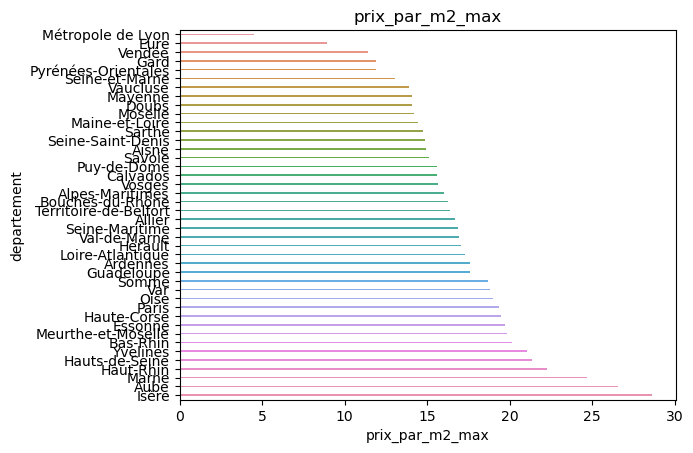

In [43]:
sns.barplot(y='departement', x='prix_par_m2_max', data=df_max, width= 0.2, orient="h").set_title('prix_par_m2_max')#OK 

## Ajout de la colonne 'prix_par_m2_mean'(qui correspond à la moyenne des loyers des logements porposés) 

In [44]:
df['prix_par_m2_mean'] = df['Mean Loyer']/df['Mean Surface'] # On crée une nouvelle variable prix_par_m2_mean

/tmp/ipykernel_1182/2695433766.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df.groupby(['departement']).mean().sort_values('prix_par_m2_mean')


Text(0.5, 1.0, 'prix_par_m2_mean')

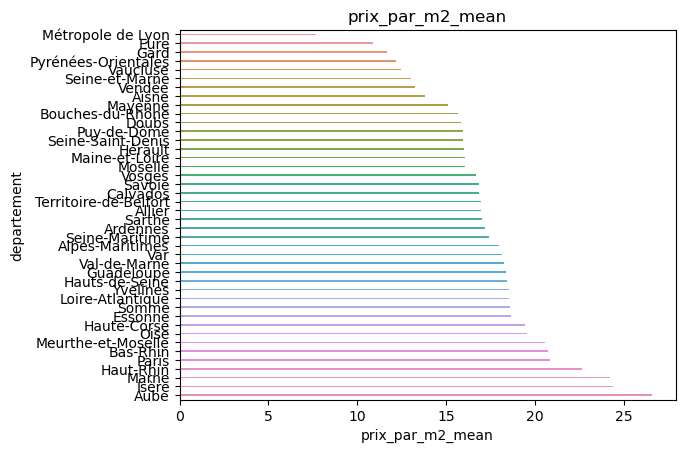

In [45]:
df_mean = df.groupby(['departement']).mean().sort_values('prix_par_m2_mean')
df_mean = df_mean.loc[(df_mean['prix_par_m2_mean']>1)] 
df_mean.columns
df_mean['departement'] = df_mean.index #je crée une colonne qui correspond à l'index (la colonne regions)
sns.barplot(y='departement', x='prix_par_m2_mean', data= df_mean, width= 0.2, orient="h").set_title('prix_par_m2_mean')#OK

## Construction de graphes pour surfaces min et max 

In [46]:
df_surface_min = df.groupby(['departement']).mean().sort_values('Min Surface')
df_surface_min

/tmp/ipykernel_1182/2751980484.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_surface_min = df.groupby(['departement']).mean().sort_values('Min Surface')


,Max Loyer,Min Loyer,Mean Loyer,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,upr.IPm2,Nbstudents_total,prix_par_m2_min,prix_par_m2_max,prix_par_m2_mean
departement,,,,,,,,,,,,,
Morbihan,NaN,NaN,NaN,9.0,9.0,9.000000,-3.081417,47.693140,12.314890,5406.000000,NaN,NaN,NaN
Allier,300.000000,220.200000,260.200000,18.0,10.0,15.333333,2.588071,46.329269,10.386274,0.000000,22.020000,16.666667,16.969565
Vosges,229.750000,211.250000,221.000000,15.5,11.5,13.500000,6.459698,48.187951,10.888784,0.000000,18.498252,15.667553,16.677636
Aube,339.000000,305.666667,324.833333,12.0,12.0,12.000000,4.077813,48.279540,13.147722,3235.000000,26.583333,26.583333,26.583333
Isère,388.083333,267.500000,323.847222,12.0,12.0,12.000000,5.744375,45.187858,15.766870,57964.000000,20.416667,28.625000,24.388889
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pas-de-Calais,NaN,NaN,NaN,NaN,NaN,NaN,2.302964,50.545309,12.709430,4506.461538,NaN,NaN,NaN
Saône-et-Loire,NaN,NaN,NaN,NaN,NaN,NaN,4.428220,46.806198,10.567857,0.000000,NaN,NaN,NaN
Val-d'Oise,364.700000,288.857143,326.778571,NaN,NaN,NaN,2.065076,49.036170,20.620895,26943.000000,NaN,NaN,NaN


Text(0.5, 1.0, 'Min Surface')

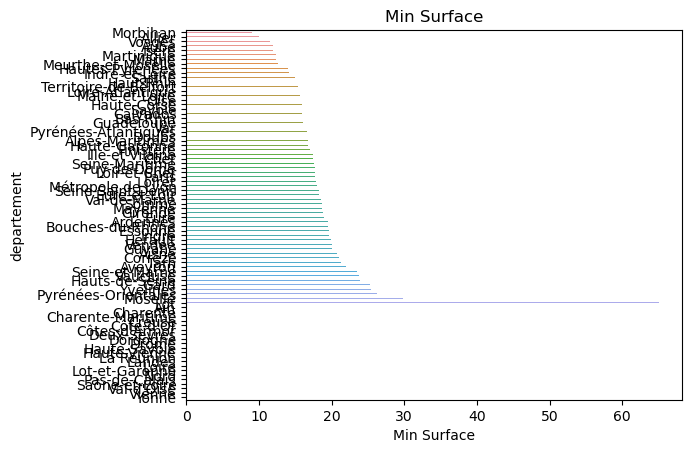

In [47]:
df_surface_min.columns
df_surface_min['departement'] = df_surface_min.index #je crée une colonne qui correspond à l'index (la colonne regions)
sns.barplot(y='departement', x='Min Surface', data= df_surface_min, width= 0.2, orient="h").set_title('Min Surface')#OK 

In [48]:
df_surface_max = df.groupby(['departement']).mean().sort_values('Max Surface')
df_surface_max

/tmp/ipykernel_1182/2977350110.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_surface_max = df.groupby(['departement']).mean().sort_values('Max Surface')


,Max Loyer,Min Loyer,Mean Loyer,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,upr.IPm2,Nbstudents_total,prix_par_m2_min,prix_par_m2_max,prix_par_m2_mean
departement,,,,,,,,,,,,,
Morbihan,NaN,NaN,NaN,9.000000,9.000000,9.000000,-3.081417,47.693140,12.314890,5406.000000,NaN,NaN,NaN
Aube,339.000000,305.666667,324.833333,12.000000,12.000000,12.000000,4.077813,48.279540,13.147722,3235.000000,26.583333,26.583333,26.583333
Isère,388.083333,267.500000,323.847222,12.000000,12.000000,12.000000,5.744375,45.187858,15.766870,57964.000000,20.416667,28.625000,24.388889
Martinique,NaN,NaN,NaN,12.333333,12.333333,12.333333,-61.090497,14.617867,19.734606,0.000000,NaN,NaN,NaN
Hautes-Pyrénées,NaN,NaN,NaN,14.000000,14.000000,14.000000,0.049889,43.227901,11.431427,1194.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pas-de-Calais,NaN,NaN,NaN,NaN,NaN,NaN,2.302964,50.545309,12.709430,4506.461538,NaN,NaN,NaN
Saône-et-Loire,NaN,NaN,NaN,NaN,NaN,NaN,4.428220,46.806198,10.567857,0.000000,NaN,NaN,NaN
Val-d'Oise,364.700000,288.857143,326.778571,NaN,NaN,NaN,2.065076,49.036170,20.620895,26943.000000,NaN,NaN,NaN


Text(0.5, 1.0, 'Max Surface')

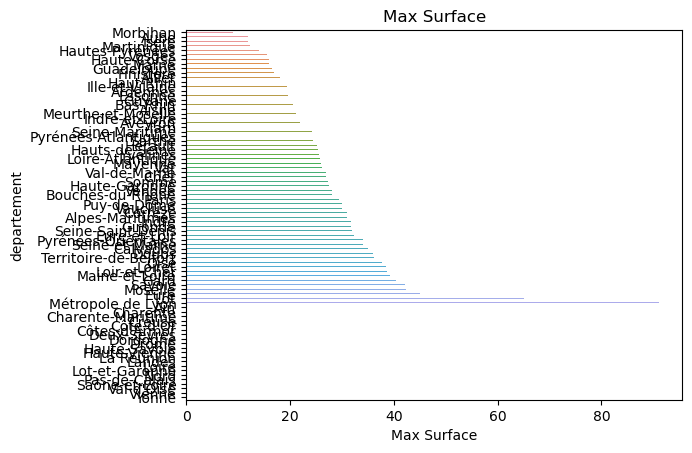

In [49]:
df_surface_max.columns
df_surface_max['departement'] = df_surface_max.index #je crée une colonne qui correspond à l'index (la colonne regions)
sns.barplot(y='departement', x='Max Surface', data= df_surface_max, width= 0.2, orient="h").set_title('Max Surface')#OK 

## Compter le nombre de residence Crous par région 

/tmp/ipykernel_1182/1075487380.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_nb_res = df.groupby(['departement']).sum().sort_values('comptage_résidence', ascending = False)


Text(0.5, 1.0, 'Nombre de résidence par départements')

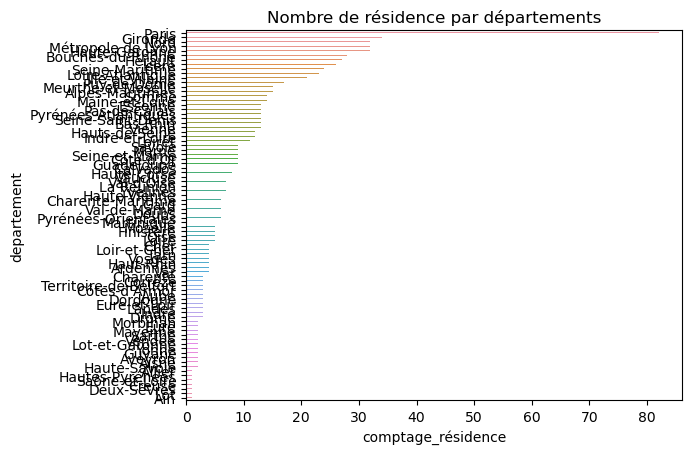

In [50]:
df['comptage_résidence']= 1
df.head(5)
df_nb_res = df.groupby(['departement']).sum().sort_values('comptage_résidence', ascending = False)

df_nb_res['departement'] = df_nb_res.index #je crée une colonne qui correspond à l'index (la colonne regions)
sns.barplot(y='departement', x='comptage_résidence', data= df_nb_res, width= 0.2, orient="h").set_title('Nombre de résidence par départements')#OK 

## 2.2 La France des Crous

On retire les territoires et régions d'Outre-Mer pour réaliser des carte

In [51]:
df_metro = df[ (df["regions"] != "La Réunion") &

                    (df["regions"] != "Guadeloupe") &

                    (df["regions"] != "Martinique") &

                    (df["regions"] != "Guyane")]

df_metro.reset_index(inplace = True)


### 2.2.1 Classical maps

In [52]:

"""
On récupère un fond de carte de la France.
"""

France = gpd.read_file("https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/france.geojson")


<AxesSubplot: >

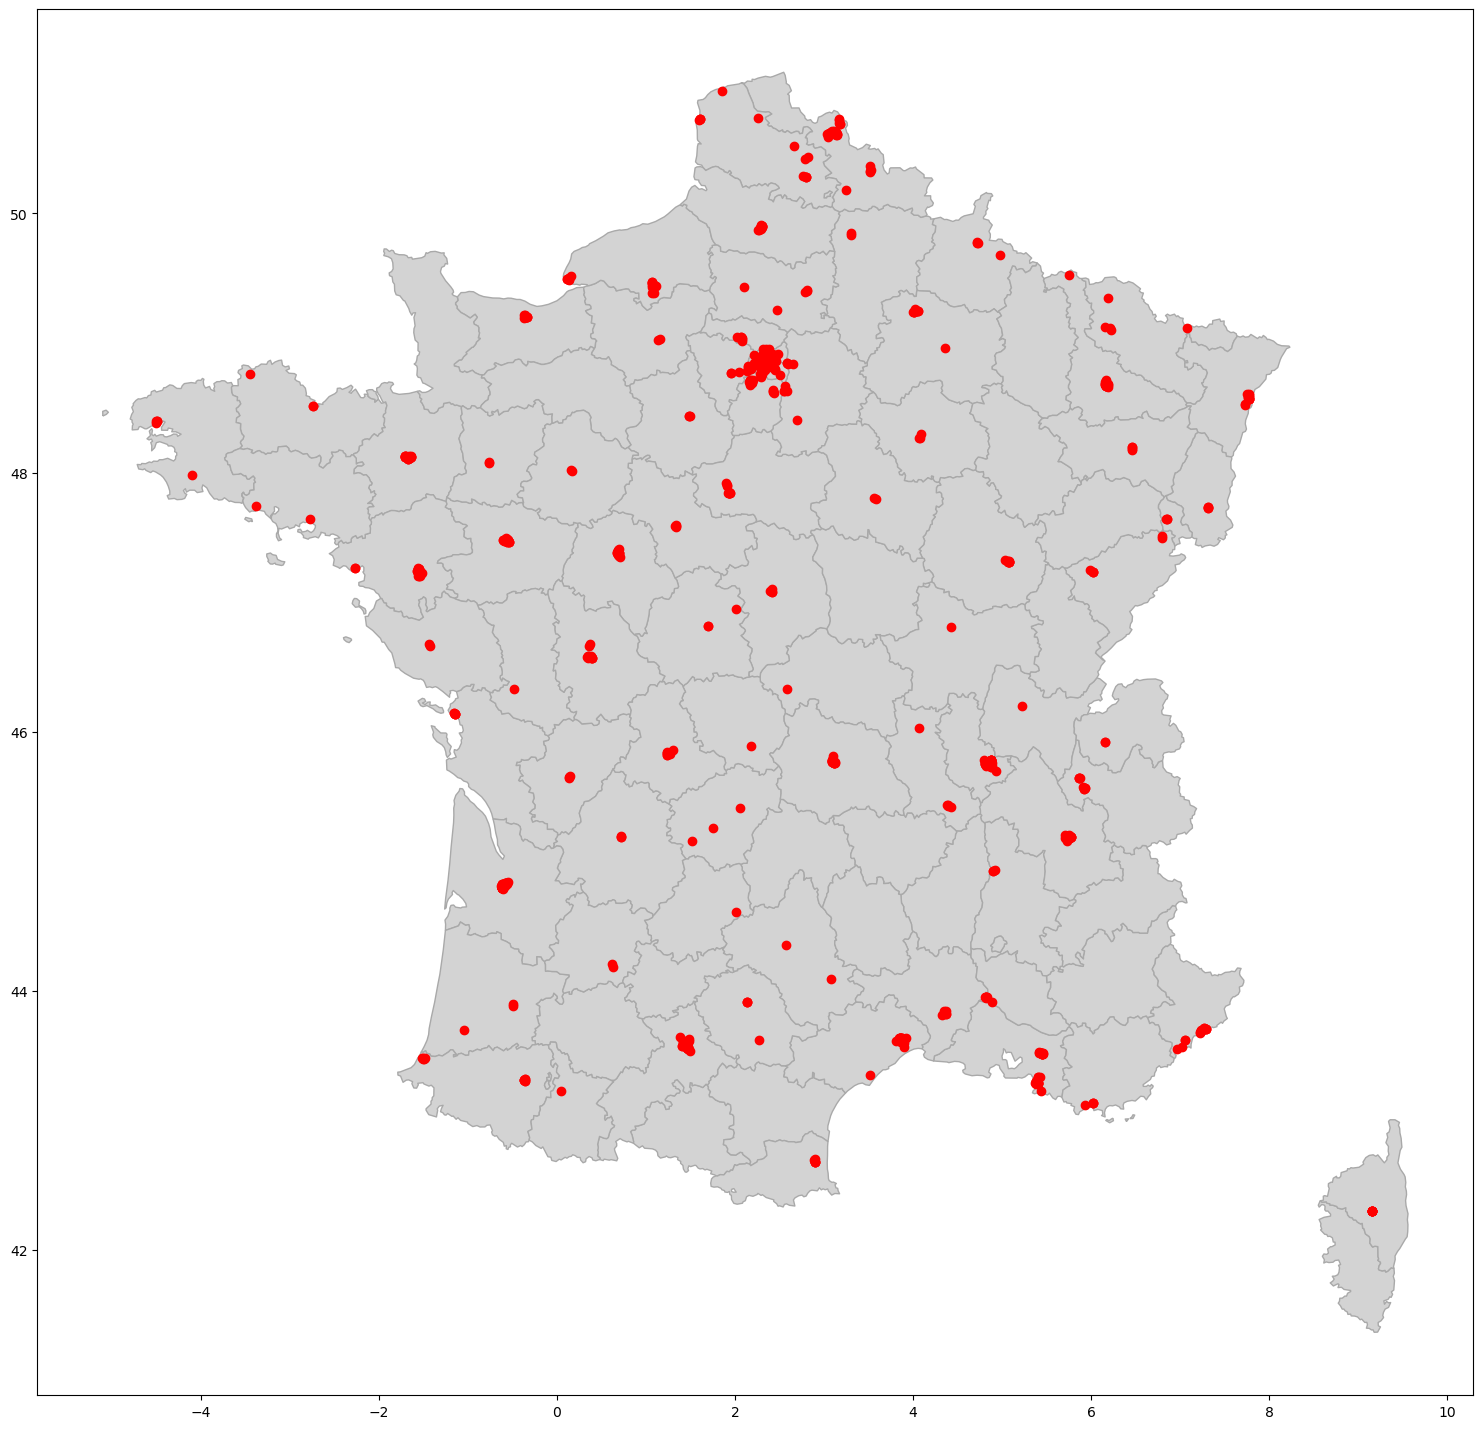

In [53]:
fig, ax = plt.subplots(figsize=(24, 18))
France.plot(ax =ax, edgecolor='darkgrey', facecolor='lightgrey')

df_metro.plot(ax = ax, color='red') 


### 2.2.2. Interactive maps

In [54]:
map = folium.Map(location=[48.7144587, 2.2453842], tiles="OpenStreetMap", zoom_start=11)

# Create a geometry list from the GeoDataFrame

geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in df_metro.geometry] 


# Iterate through list and add a marker for each residence, color-coded by its type.

i = 0

for coordinates in geo_df_list:

    # Place the markers with the popup labels and data

    map.add_child(

        folium.Marker(

            location=coordinates,

            popup=

                 "Name: " + str(df_metro.title[i]) + "<br>"

                + "Moyenne Loyer: " + str(df_metro["Mean Loyer"][i]) + "<br>"

                + "Moyenne surface: " + str(df_metro["Mean Surface"][i]) + "<br>"

                + "Address: " + str(df_metro.address[i]) + "<br>"

                + "Coordinates: " + str(geo_df_list[i])

            ,

        

            icon=folium.Icon(color="blue"),

        )

    )

    i = i + 1

map

### 2.2.3 cartes statistiques 

In [55]:
gdf_mean = df_metro.groupby(['departement']).mean().sort_values('prix_par_m2_mean')
gdf_mean['departement'] = gdf_mean.index

/tmp/ipykernel_1182/615003632.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gdf_mean = df_metro.groupby(['departement']).mean().sort_values('prix_par_m2_mean')


In [56]:
gpd_mean = gpd.GeoDataFrame(gdf_mean.set_index('departement').join(gdf_dep.set_index('departement')))

In [57]:
gpd_mean_wout_nan = gpd_mean[gpd_mean['prix_par_m2_mean'] > 1]

/opt/mamba/lib/python3.10/site-packages/geoplot/geoplot.py:982: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


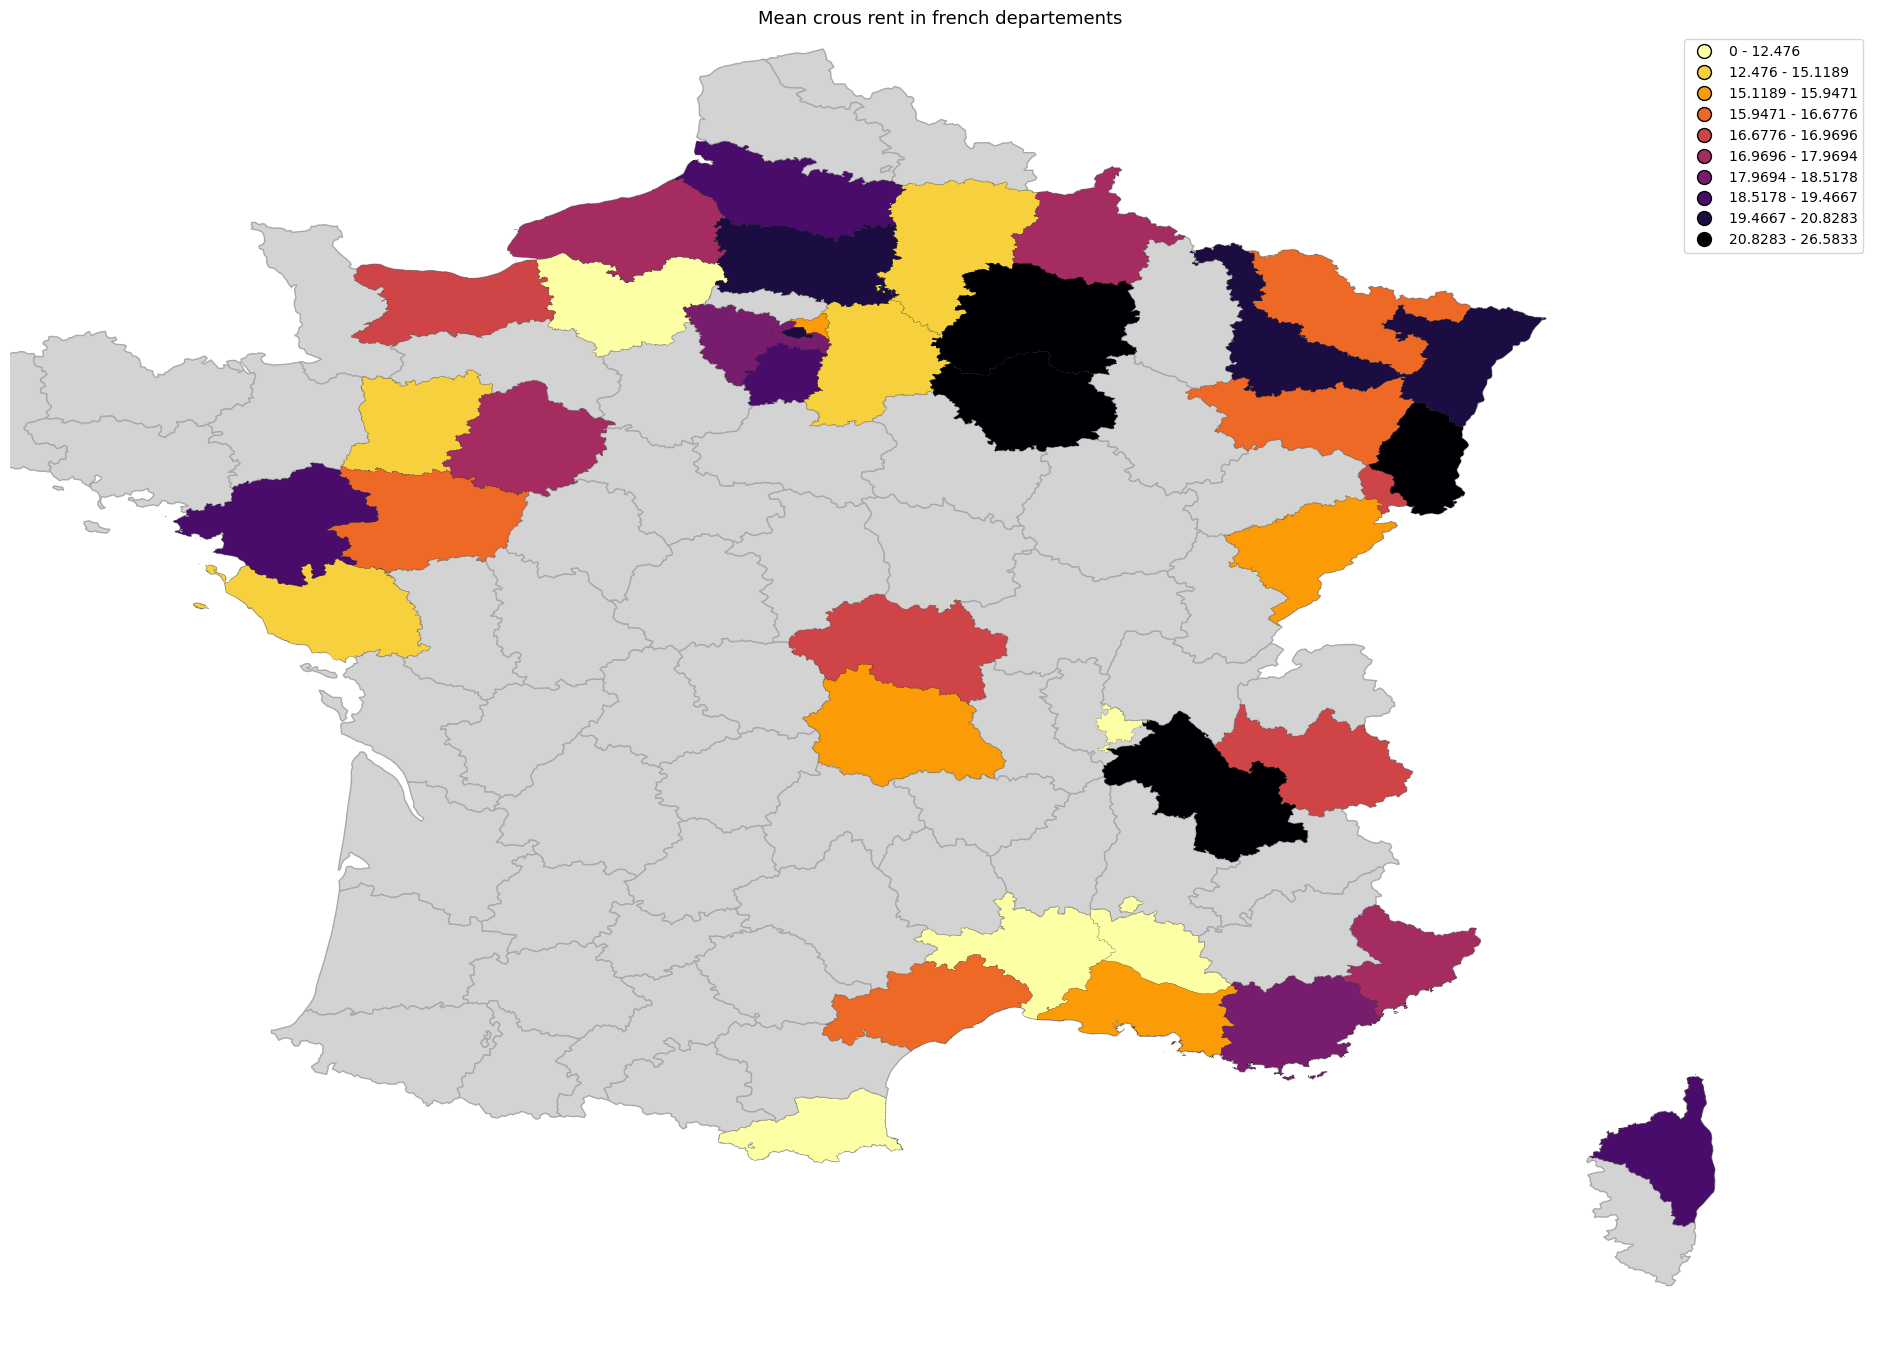

In [58]:
fig, ax = plt.subplots(figsize=(24, 18))
France.plot(ax =ax, edgecolor='darkgrey', facecolor='lightgrey')

# Set up the color sheme:
import mapclassify as mc
scheme = mc.Quantiles(gpd_mean_wout_nan['prix_par_m2_mean'], k=10)

# Map
gplt.choropleth(gpd_mean_wout_nan, 
    hue="prix_par_m2_mean", 
    linewidth=.1,
    scheme=scheme, cmap='inferno_r',
    legend=True,
    edgecolor='black',
    ax=ax
                
);

ax.set_title('Mean crous rent in french departements', fontsize=13);



/opt/mamba/lib/python3.10/site-packages/geoplot/geoplot.py:982: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


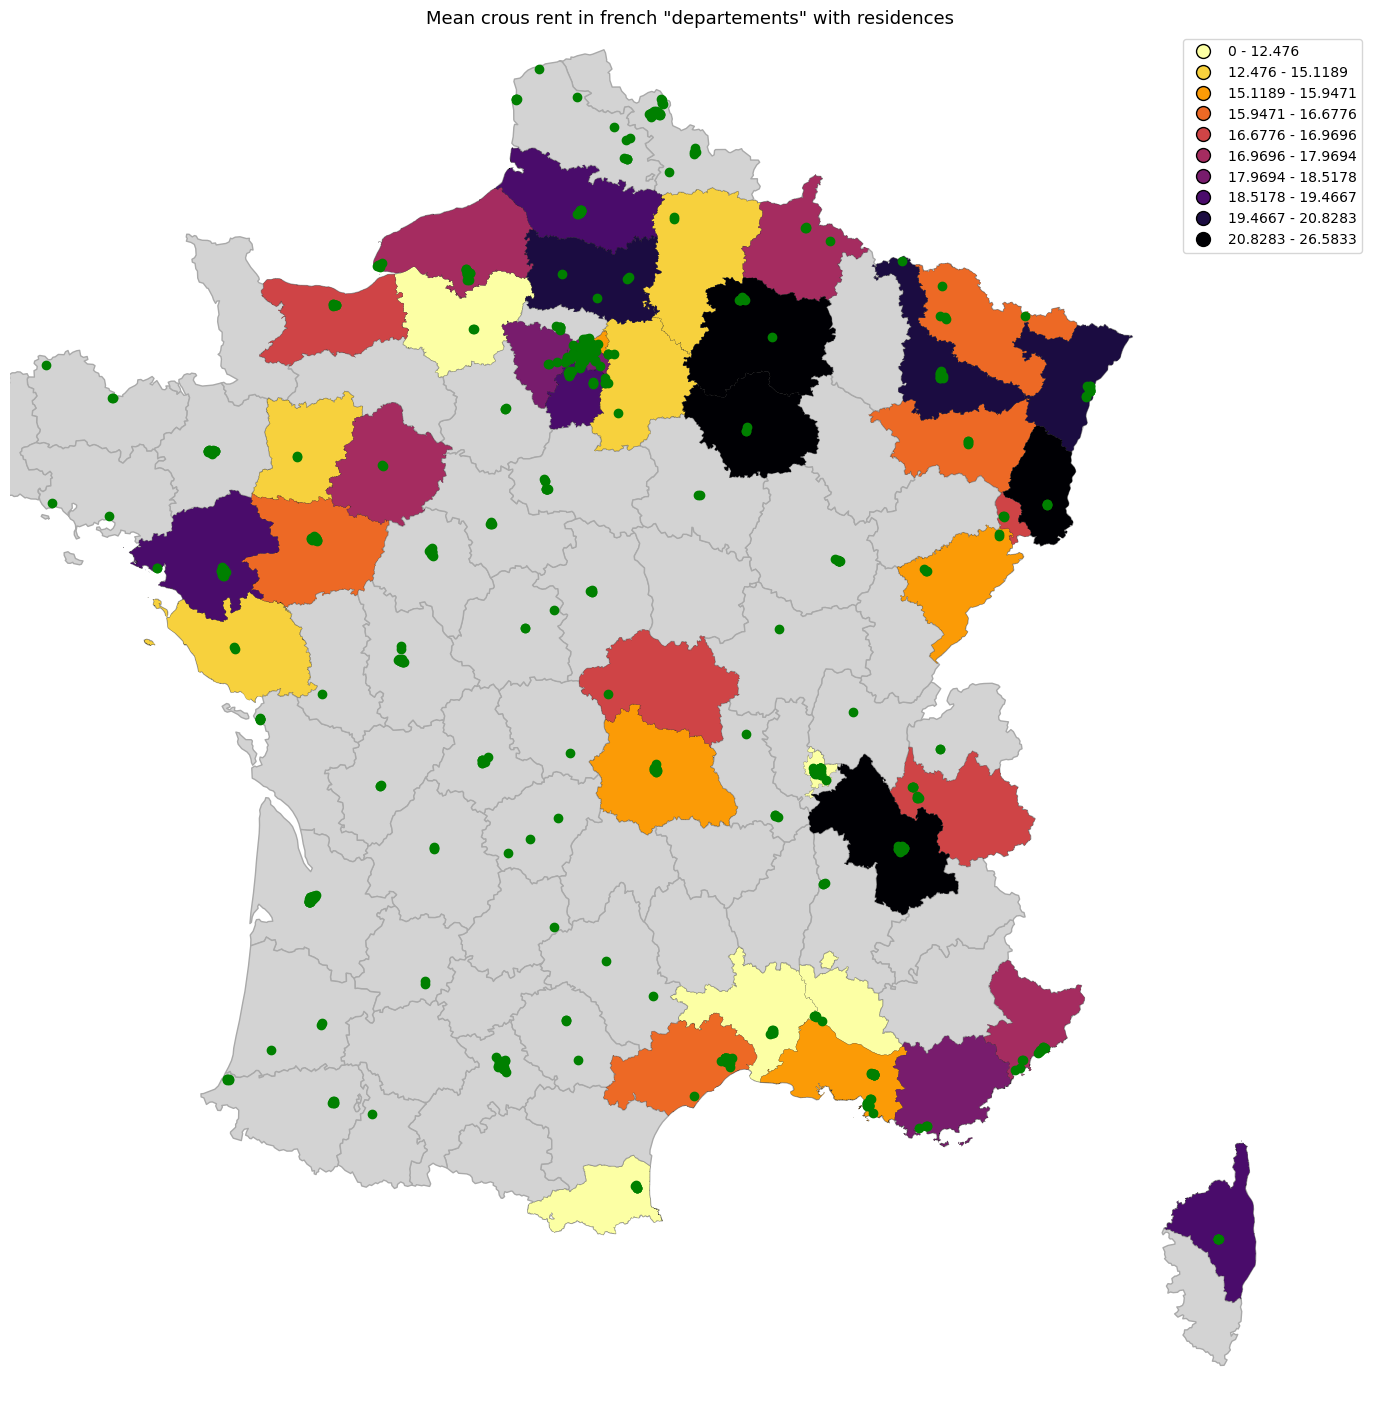

In [59]:
fig, ax = plt.subplots(figsize=(24, 18))
France.plot(ax =ax, edgecolor='darkgrey', facecolor='lightgrey')

# Set up the color sheme:
import mapclassify as mc
scheme = mc.Quantiles(gpd_mean_wout_nan['prix_par_m2_mean'], k=10)

# Map
gplt.choropleth(gpd_mean_wout_nan, 
    hue="prix_par_m2_mean", 
    linewidth=.1,
    scheme=scheme, cmap='inferno_r',
    legend=True,
    edgecolor='black',
    ax=ax
);
ax.set_title('Mean crous rent in french "departements" with residences', fontsize=13)

df_metro.plot(ax = ax, color='green');

# Modélisation 

On commence par enlever les NaN du dataframe qui bloquent la regression linéaire

In [60]:
from sklearn.linear_model import LinearRegression
import math
from sklearn.model_selection import train_test_split

In [61]:
df.isnull().sum()
df2 = df
index_with_nan = df2.index[df2.isnull().any(axis=1)]
print(index_with_nan.shape)
df2.drop(index_with_nan,0, inplace=True)
df2[['Mean Loyer', 'Mean Surface']].isnull().sum()

(423,)


/tmp/ipykernel_1182/496102278.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df2.drop(index_with_nan,0, inplace=True)


Mean Loyer      0
Mean Surface    0
dtype: int64

In [62]:
df2 = df2.reset_index()
df2

,index,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,...,LIBGEO,upr.IPm2,departement,Schools,Nbstudents,Nbstudents_total,prix_par_m2_min,prix_par_m2_max,prix_par_m2_mean,comptage_résidence
0,2,Résidence Les Bas Longchamps,Description Résidence universitaire située à p...,2 rue Abraham Lincoln 92220 Bagneux,"48.7906913757,2.3169708252",Île-de-France,"[332.0, 359.0]",359.00,332.00,345.500000,...,Bagneux,24.982816,Hauts-de-Seine,"[Université Paris Lumières, Université Paris 1...","[78, 40413, 15404, 1937, 22246, 422, 52969, 59...",275639,11.857143,12.821429,12.339286,1
1,3,Résidence de l’Ile,Description Résidence universitaire située à p...,14 rue du Docteur Collé - bâtiment 227 du camp...,"48.698802948,2.1578958035",Île-de-France,[362.0],362.00,362.00,362.000000,...,Bures-sur-Yvette,21.271351,Essonne,[Université Paris-Saclay],[48595],48595,20.111111,20.111111,20.111111,1
2,5,Résidence La Fresque,Description Résidence universitaire située aux...,10 rue Edmé Bouchardon 78000 Versailles,"48.8112220764,2.1460649967",Île-de-France,"[424.0, 537.0]",537.00,424.00,480.500000,...,Versailles,28.519253,Yvelines,[Université de Versailles Saint-Quentin-en-Yve...,"[14583, 48595, 305]",63483,16.758893,21.225296,18.992095,1
3,15,Résidence Fernand Braudel,Localisation :\r\n La résidence Fernand Braude...,Rue Ernest Duvillard 90016 Belfort,"47.6403808594,6.8530831337",Bourgogne-Franche-Comté,"[277.0, 321.0, 427.0, 399.0]",427.00,277.00,356.000000,...,Belfort,13.046841,Territoire-de-Belfort,[Université de technologie de Belfort-Montbéli...,[2641],2641,14.578947,8.933054,10.595238,1
4,16,Résidence Portes du Jura,Localisation :\r\n A 5 minutes à pied du resto...,23 rue Maurice Ravel 25200 Montbéliard,"47.4966392517,6.8003001213",Bourgogne-Franche-Comté,[339.0],339.00,339.00,339.000000,...,Montbéliard,12.278547,Doubs,[Université de technologie de Belfort-Montbéli...,[2641],2641,18.833333,18.833333,18.833333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,781,Résidence du Panorama (secteur Rouen),Localisation\r\n Proche de l'université \r\nDe...,Boulevard Siegfried 76130 Mont-Saint-Aignan,"49.4621658325,1.0657054186",Normandie,"[248.0, 288.0, 315.0, 203.0, 344.0, 430.0]",430.00,203.00,304.666667,...,Mont-Saint-Aignan,14.845433,Seine-Maritime,"[Université de Rouen Normandie, Institut natio...","[34398, 2044]",36442,22.555556,8.600000,14.585106,1
361,782,Résidence Emma Bovary (secteur Rouen),Localisation\r\n Rouen \r\nDescription\r\n T1 ...,4 boulevard Gambetta 76000 ROUEN,"49.4363975525,1.1012332439",Normandie,"[381.1, 417.7]",417.70,381.10,399.400000,...,Rouen,14.850004,Seine-Maritime,"[Université de Rouen Normandie, Institut natio...","[34398, 2044]",36442,21.172222,19.890476,20.482051,1
362,783,Cité Grémillon (secteur d'Hérouville-Saint-Clair),BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,"49.2032051086,-0.3392136097",Normandie,"[249.85, 312.9, 388.6, 467.4, 525.0, 556.14]",556.14,249.85,416.648333,...,Hérouville-Saint-Clair,13.705407,Calvados,[École nationale supérieure d'ingénieurs de Ca...,"[845, 32088]",32933,27.761111,8.060000,10.416208,1
363,784,Résidence Antide Janvier,"Localisation :\r\n Au centre ville, à proximit...",6 rue Antide Janvier 25000 Besançon,"47.2365074158,6.0153431892",Bourgogne-Franche-Comté,"[347.0, 502.0, 523.0]",523.00,347.00,457.333333,...,Besançon,13.926095,Doubs,"[Université Bourgogne - Franche-Comté, École n...","[2077, 779, 23578]",26434,18.263158,14.815864,16.844690,1


Régression linéaire de la moyenne des loyers sur la moyenne des surfaces

In [130]:
df2['Mean Surface'].describe()

count    365.000000
mean      22.712599
std        9.287976
min        9.000000
25%       18.000000
50%       21.000000
75%       26.666667
max       88.000000
Name: Mean Surface, dtype: float64

In [63]:
var_explicatives = df2['Mean Surface']
YLoyer = df2['Mean Loyer']
#on transforme Y et X en array que l'on reformate
YLoyer = np.array(YLoyer).reshape(-1,1)
var_explicatives = (np.array(var_explicatives).reshape(-1,1))

In [131]:
X_train, X_test, Y_train, Y_test = train_test_split(var_explicatives,YLoyer,test_size=0.3,train_size=0.7)
lin= LinearRegression()
reg = lin.fit(X_train,Y_train)
pred_train = lin.predict(X_train)
pred_test = lin.predict(X_test)

coefficients_sans_cst= reg.coef_
r_2 = reg.score(X_train,Y_train)
print(r_2)
print(coefficients_sans_cst)

0.14728724746432353
[[3.39658429]]


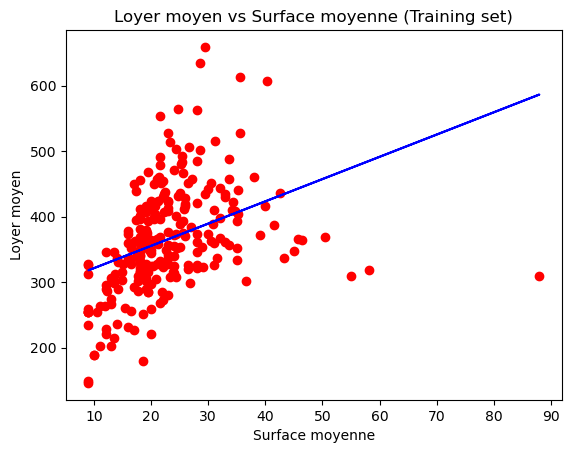

In [132]:

plt.scatter(X_train, Y_train, color='red') # plotting the observation line
 
plt.plot(X_train, lin.predict(X_train), color='blue') # plotting the regression line
 
plt.title("Loyer moyen vs Surface moyenne (Training set)") # stating the title of the graph
 
plt.xlabel("Surface moyenne") # adding the name of x-axis
plt.ylabel("Loyer moyen") # adding the name of y-axis
plt.show() # specifies end of graph


In [ ]:
#Deuxième essai: regression linéaire du min Loyer sur min surface 

In [68]:
df2[['Min Loyer', 'Min Surface']].isnull().sum()

Min Loyer      0
Min Surface    0
dtype: int64

In [69]:
X_min_surface = df2['Min Surface'] #la variable explicative
Y_min_Loyer = df2['Min Loyer']
#on transforme Y et X en array que l'on reformate
Y_min_Loyer = np.array(Y_min_Loyer).reshape(-1,1)
X_min_surface = (np.array(X_min_surface).reshape(-1,1))

In [87]:
X_train, X_test, Y_train, Y_test = train_test_split(X_min_surface,Y_min_Loyer,test_size=0.2,train_size=0.8)
lin= LinearRegression()
reg = lin.fit(X_train,Y_train)
pred_train = lin.predict(X_train)
pred_test = lin.predict(X_test)

coefficients_sans_cst= reg.coef_
r_2 = reg.score(X_train,Y_train)
print(r_2)
print(coefficients_sans_cst) 

0.05969103068990966
[[2.63561164]]


In [ ]:
#avec la régression du min Loyer sur min Surface, on a un R² peu significatif

In [90]:
#Regression linéaire du Loyer sur le nombre total d'étudiants

In [139]:
df2['Nbstudents_total'].describe()

count       365.000000
mean      94583.860274
std      112340.516643
min           1.000000
25%       10652.000000
50%       36442.000000
75%      110738.000000
max      323129.000000
Name: Nbstudents_total, dtype: float64

In [136]:
X_Nbstudents = df2['Nbstudents_total'] #la variable explicative
YLoyer = df2['Mean Loyer']
#on transforme Y et X en array que l'on reformate
YLoyer = np.array(YLoyer).reshape(-1,1)
X_Nbstudents = (np.array(X_Nbstudents).reshape(-1,1))

In [137]:
X_train, X_test, Y_train, Y_test = train_test_split(X_Nbstudents,YLoyer,test_size=0.2,train_size=0.8)
lin= LinearRegression()
reg = lin.fit(X_train,Y_train)
pred_train = lin.predict(X_train)
pred_test = lin.predict(X_test)

coefficients_sans_cst= reg.coef_
r_2 = reg.score(X_train,Y_train)
print(r_2)
print(coefficients_sans_cst) 

0.2545438942399133
[[0.00038665]]


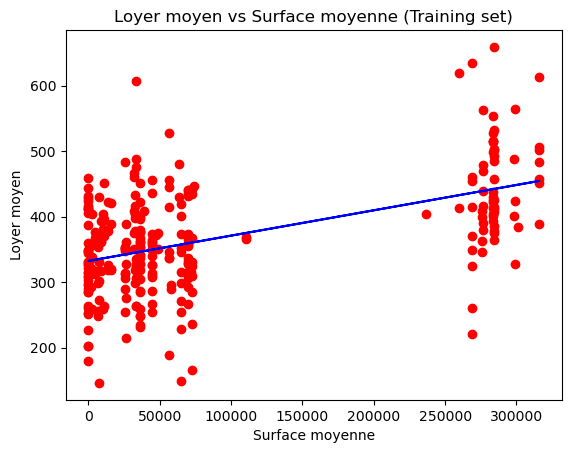

In [138]:
plt.scatter(X_train, Y_train, color='red') # plotting the observation line
 
plt.plot(X_train, lin.predict(X_train), color='blue') # plotting the regression line
 
plt.title("Loyer moyen vs Surface moyenne (Training set)") # stating the title of the graph
 
plt.xlabel("Surface moyenne") # adding the name of x-axis
plt.ylabel("Loyer moyen") # adding the name of y-axis
plt.show() # specifies end of graph

In [98]:
#Regression linéaire du Loyer sur le LOG du nombre total d'étudiants

In [122]:
for i in range (0, (np.shape(df2['Nbstudents_total']))[0]): 
    if  df2['Nbstudents_total'][i]==0: 
        df2['Nbstudents_total'][i]=1 #cela permet de ne pas avoir de valeur 0 quand on applique le log
df2['Nbstudents_total'].describe()

len(df2[df2['Nbstudents_total']==0])

/tmp/ipykernel_1182/3281078151.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Nbstudents_total'][i]=1 #cela permet de ne pas avoir de valeur 0 quand on applique le log


0

In [123]:
X_log_Nbstudents = np.log(df2['Nbstudents_total']) #la variable explicative
YLoyer = df2['Mean Loyer']
#on transforme Y et X en array que l'on reformate
YLoyer = np.array(YLoyer).reshape(-1,1)
X_log_Nbstudents = (np.array(X_log_Nbstudents).reshape(-1,1))

In [124]:
X_train, X_test, Y_train, Y_test = train_test_split(X_log_Nbstudents,YLoyer,test_size=0.2,train_size=0.8)
lin= LinearRegression()
reg = lin.fit(X_train,Y_train)
pred_train = lin.predict(X_train)
pred_test = lin.predict(X_test)

coefficients_sans_cst= reg.coef_
r_2 = reg.score(X_train,Y_train)
print(r_2)
print(coefficients_sans_cst) 

0.10523821274587619
[[6.77162411]]


In [126]:
df2.columns

Index(['index', 'title', 'infos', 'address', 'geocalisation', 'regions',
       'Loyer', 'Max Loyer', 'Min Loyer', 'Mean Loyer', 'Surface',
       'Max Surface', 'Min Surface', 'Mean Surface', 'Longitude', 'Latitude',
       'geometry', 'LIBGEO', 'upr.IPm2', 'departement', 'Schools',
       'Nbstudents', 'Nbstudents_total', 'prix_par_m2_min', 'prix_par_m2_max',
       'prix_par_m2_mean', 'comptage_résidence'],
      dtype='object')

In [ ]:
#régression linéaire du 